In [1]:
!pip install tensorflow-addons==0.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.9 MB/s eta 0:00:00a 0:00:01


In [2]:
# Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [3]:
# Configuration
IMG_SIZE = (180, 180)
BATCH_SIZE = 32
EPOCHS = 2
SEED = 42
CLASS_NAMES = ['Eczema', 'ACNE', 'Psoriasis', 'NORMAL SKIN', 'Others']
BASE_PATH = "/kaggle/input/acne-psoriasis-eczema-vs-all-skin-diseases/Acne_Psoriasis_Eczema_vs_All_skin_Diseases/"
DOMAIN_CLASSES = ['Eczema', 'ACNE', 'Psoriasis']  # Classes in our domain of interest

In [4]:
# 1. Data Preparation
def create_dataframe():
    data_dict = {"image_path": [], "target": []}
    
    class_info = [
        ("Eczema", 0),
        ("ACNE", 1),
        ("Psoriasis", 2),
        ("NORMAL SKIN", 3),
        ("Other", 4)
    ]
    
    for class_dir, label in class_info:
        full_path = os.path.join(BASE_PATH, class_dir)
        if not os.path.exists(full_path):
            raise FileNotFoundError(f"Directory not found: {full_path}")
            
        for img_file in os.listdir(full_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(full_path, img_file)
                data_dict["image_path"].append(img_path)
                data_dict["target"].append(label)
                
    return pd.DataFrame(data_dict)

df = create_dataframe()
print("Class distribution:\n", df['target'].value_counts())

Class distribution:
 target
4    31851
1     4197
2     3812
0     3200
3     2158
Name: count, dtype: int64


In [5]:
# 2. Handle Class Imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("\nClass weights:", class_weights)


Class weights: {0: 2.826125, 1: 2.154777221825113, 2: 2.372402938090241, 3: 4.190732159406858, 4: 0.28393457034316033}


In [6]:
# 3. Image Loading and Preprocessing
def load_images(df):
    images = []
    labels = []
    
    for idx, row in df.iterrows():
        try:
            img = cv2.imread(row['image_path'])
            if img is None:
                raise ValueError("Could not read image")
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            images.append(img)
            labels.append(row['target'])
        except Exception as e:
            print(f"Error processing {row['image_path']}: {str(e)}")
    
    return np.array(images), np.array(labels)

images, labels = load_images(df)

In [7]:
# 4. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    images, 
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=SEED
)


In [8]:
# 5. Feature Extraction with VGG19
def create_feature_extractor():
    base_model = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    base_model.trainable = False
    return base_model

vgg_model = create_feature_extractor()

def extract_features(images, model):
    features = model.predict(images, verbose=0)
    return features.reshape(features.shape[0], -1)

print("\nExtracting training features...")
X_train_features = extract_features(X_train, vgg_model)
print("Extracting test features...")
X_test_features = extract_features(X_test, vgg_model)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Extracting training features...
Extracting test features...


In [9]:
# 6. Simplified Model Architecture
def build_model(input_shape):
    model = Sequential([
        Dense(512, activation='relu', 
              input_shape=input_shape,
              kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(256, activation='relu',
              kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(5, activation='softmax')  # Updated to 5 classes
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model((X_train_features.shape[1],))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,686,725 (25.51 MB)

 Trainable params: 6,686,725 (25.51 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 7. Training with Essential Callbacks Only
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1
    )
]

In [11]:
history = model.fit(
    X_train_features, y_train,
    validation_data=(X_test_features, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/2
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5260 - loss: 16.4809 - val_accuracy: 0.6533 - val_loss: 11.5495 - learning_rate: 1.0000e-04
Epoch 2/2
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6202 - loss: 11.1166 - val_accuracy: 0.6535 - val_loss: 9.4399 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.


283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

      Eczema       0.30      0.74      0.43       640
        ACNE       0.63      0.85      0.72       839
   Psoriasis       0.28      0.71      0.40       762
 NORMAL SKIN       0.76      0.97      0.85       432
      Others       0.98      0.59      0.74      6371

    accuracy                           0.65      9044
   macro avg       0.59      0.77      0.63      9044
weighted avg       0.83      0.65      0.69      9044



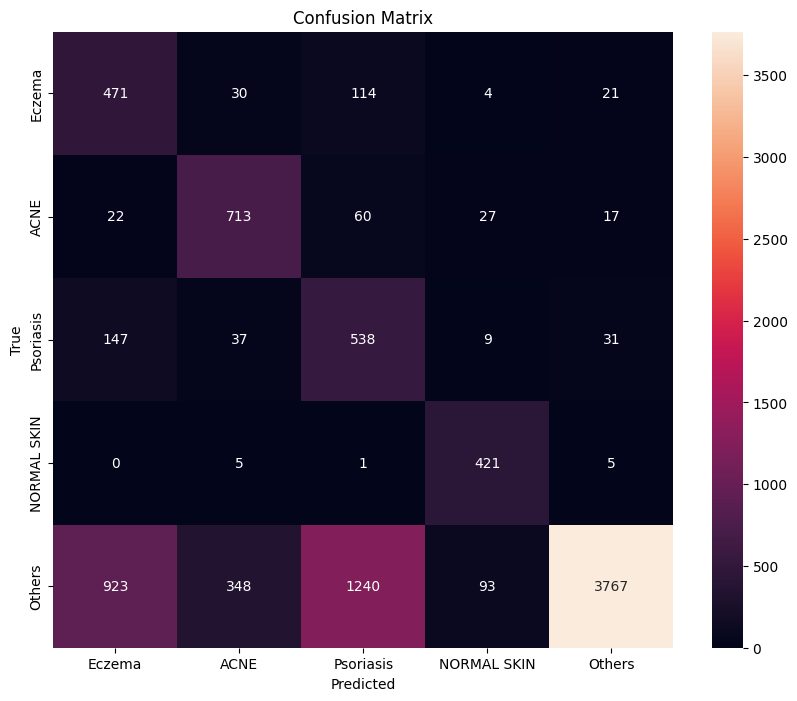

In [12]:
# 8. Post-Training Evaluation
y_pred = np.argmax(model.predict(X_test_features), axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
# Function to interpret predictions
def interpret_prediction(class_index):
    class_name = CLASS_NAMES[class_index]
    if class_name in DOMAIN_CLASSES:
        return f"Predicted: {class_name}"
    else:
        return "Not in my domain"

In [15]:
# Display some examples with interpretations
print("\nSample Test Predictions with Interpretations:")
for i in range(min(10, len(y_test))):
    true_class = CLASS_NAMES[y_test[i]]
    pred_class = CLASS_NAMES[y_pred[i]]
    interpretation = interpret_prediction(y_pred[i])
    print(f"Sample {i+1}: True class = {true_class}, {interpretation}")


Sample Test Predictions with Interpretations:
Sample 1: True class = Others, Not in my domain
Sample 2: True class = Others, Not in my domain
Sample 3: True class = Others, Not in my domain
Sample 4: True class = Psoriasis, Predicted: Psoriasis
Sample 5: True class = Eczema, Predicted: Eczema
Sample 6: True class = ACNE, Predicted: ACNE
Sample 7: True class = Psoriasis, Predicted: Eczema
Sample 8: True class = Eczema, Predicted: Eczema
Sample 9: True class = Others, Predicted: Psoriasis
Sample 10: True class = ACNE, Predicted: ACNE


In [16]:
# 9. Save Model
model.save('skin_disease_classifier_v2.h5')
print("Model saved successfully!")
import shutil
shutil.move('skin_disease_classifier_v2.h5', '/kaggle/working/skin_disease_classifier_v2.h5')

Model saved successfully!


'/kaggle/working/skin_disease_classifier_v2.h5'

In [17]:
# Load the saved model (if not already loaded)
from tensorflow.keras.models import load_model
import numpy as np

# 1. Load the trained model
model = load_model('skin_disease_classifier_v2.h5')

# 2. Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_features, y_test, verbose=0)

# 3. Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 65.35%
Test Loss: 9.4399


In [18]:
# Optional: Detailed prediction analysis
from sklearn.metrics import accuracy_score

# Make predictions
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate manual accuracy (should match evaluate() result)
manual_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\nManual Accuracy Check: {manual_accuracy * 100:.2f}%")

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Manual Accuracy Check: 65.35%


In [ ]:
# Confirmation check
assert np.isclose(test_accuracy, manual_accuracy), "Accuracy values should match!"

# Analyze in-domain vs out-of-domain predictions
domain_indices = np.array([i for i, name in enumerate(CLASS_NAMES) if name in DOMAIN_CLASSES])
in_domain_samples = np.isin(y_test, domain_indices)
out_domain_samples = ~in_domain_samples

# For in-domain samples (the 3 main diseases)
if np.any(in_domain_samples):
    in_domain_accuracy = accuracy_score(y_test[in_domain_samples], y_pred_classes[in_domain_samples])
    print(f"\nMain Diseases Accuracy: {in_domain_accuracy * 100:.2f}%")

# For out-of-domain samples
if np.any(out_domain_samples):
    # For these, we want to check if the model correctly identified them as not in domain
    correctly_identified = np.isin(y_pred_classes[out_domain_samples], [3, 4])  # NORMAL SKIN or Others
    print(f"Not-in-domain recognition rate: {np.mean(correctly_identified) * 100:.2f}%")


In [ ]:
# Function for making a prediction on a new image
def predict_skin_condition(image_path):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = np.expand_dims(img, axis=0)
    
    # Extract features using VGG19
    features = vgg_model.predict(img, verbose=0)
    features = features.reshape(1, -1)
    
    # Make prediction
    prediction = model.predict(features, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class] * 100
    
    # Interpret the result
    if predicted_class in [0, 1, 2]:  # Main diseases
        result = f"Prediction: {CLASS_NAMES[predicted_class]} (Confidence: {confidence:.2f}%)"
    else:  # NORMAL SKIN or Others
        result = f"Not in my domain (Detected as: {CLASS_NAMES[predicted_class]}, Confidence: {confidence:.2f}%)"
        
    return result

In [ ]:
# Test the prediction function on a few sample images if available
import random

# Test with some random samples from the test set (if available)
print("Example predictions on test samples:")
test_indices = random.sample(range(len(X_test)), min(5, len(X_test)))

for idx in test_indices:
    # Save the test image temporarily
    temp_img_path = f"temp_test_image_{idx}.jpg"
    plt.imsave(temp_img_path, X_test[idx])
    
    # Make prediction
    true_class = CLASS_NAMES[y_test[idx]]
    prediction_result = predict_skin_condition(temp_img_path)
    
    # Display results
    print(f"\nSample {idx}:")
    print(f"True class: {true_class}")
    print(f"{prediction_result}")
    
    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(X_test[idx])
    plt.title(f"True: {true_class}\n{prediction_result}")
    plt.axis('off')
    plt.show()
    
    # Clean up
    os.remove(temp_img_path)